<head>
<link rel="stylesheet" href="../../../cssthemes/github.css">
<meta name="viewport" content="initial-scale=1, width=device-width">
</head>

In [293]:
import datetime
time_start = datetime.datetime.now()
import sys
print(sys.executable)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
InteractiveShell.colors = "Linux"
InteractiveShell.separate_in = 0

/home/jcmint/anaconda3/envs/learningenv/bin/python


# Clustering - kmeans
The clustering tutorial was based on weather data and classifying them into hot or cold days based on 7-8 features. However, I wanted to try something on my own using the movies rating data. I wanted to 2-D graph movies by the number of raters and the average score, and plot. Then, I would use a third variable (the decade it was released) to color the points, to see if movies released in certain decades were more actively reviewed or had higher. A fourth variable, the average review timestamp, would be used as intensity for a heatmap for the color variable.
After assessing the data, I would then run the data through a cluster algoritm, including generating an elbow curve.
Installed seaborn from conda for leanringenv

In [294]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from itertools import cycle, islice
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set(style="ticks", context="talk")

In [295]:
movies = pd.read_csv('../../../../data/w4pd/movies.csv')
ratings = pd.read_csv('../../../../data/w4pd/ratings.csv')

In [296]:
movies.shape, ratings.shape
movies.head()
ratings.head()

((27278, 3), (20000263, 4))

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


# Data Prep
## Joining data
Here, I join together two tables and calculate aggregate values, so that I condense the information from million of rows into a few tens of thousands.

In [297]:
movie_ratings = ratings[['movieId', 'rating']].groupby('movieId').mean()
movie_counts = ratings[['movieId', 'rating']].groupby('movieId').count()
movie_timestamps = pd.to_datetime(ratings[['movieId', 'timestamp']].groupby('movieId').mean()['timestamp'], unit = 's').dt.date

In [298]:
print("Timestamp range is ", movie_timestamps.min(), " to ", movie_timestamps.max())

Timestamp range is  1997-03-02  to  2015-03-30


Join all three on Movie ID

In [299]:
merged_1 = movie_ratings.merge(movie_counts, on = 'movieId', how='inner').merge(movie_timestamps, on = 'movieId', how='inner')
merged_1 = merged_1.merge(movies[['movieId', 'title']], on = 'movieId', how='inner')
merged_1.head()

,movieId,rating_x,rating_y,timestamp,title
0,1,3.921240,49695,2003-05-11,Toy Story (1995)
1,2,3.211977,22243,2002-11-18,Jumanji (1995)
2,3,3.151040,12735,2000-05-30,Grumpier Old Men (1995)
3,4,2.861393,2756,1999-04-15,Waiting to Exhale (1995)
4,5,3.064592,12161,2000-06-26,Father of the Bride Part II (1995)


## Splitting columns - title and year
Next, extract the year from the title and bin into a decade

In [300]:
Title = merged_1['title'].str.extract('(.+?) \(')
Year  = merged_1['title'].str.extract('(\d\d\d\d)')
Title = Title.rename(columns = {Title.columns[0]: "Name"})
Year = Year.rename(columns = {Year.columns[0]: "Year"})
merged_1 = pd.concat([merged_1, Title, Year], axis = 1, join = "inner")
merged_1.head()

,movieId,rating_x,rating_y,timestamp,title,Name,Year
0,1,3.921240,49695,2003-05-11,Toy Story (1995),Toy Story,1995
1,2,3.211977,22243,2002-11-18,Jumanji (1995),Jumanji,1995
2,3,3.151040,12735,2000-05-30,Grumpier Old Men (1995),Grumpier Old Men,1995
3,4,2.861393,2756,1999-04-15,Waiting to Exhale (1995),Waiting to Exhale,1995
4,5,3.064592,12161,2000-06-26,Father of the Bride Part II (1995),Father of the Bride Part II,1995


Finally, drop the title column since it's been split

In [301]:
del merged_1['title']
merged_1 = merged_1.rename(columns={merged_1.columns[1]: "Score", merged_1.columns[2] : "Ratings", merged_1.columns[3]:"Date"})
merged_1.head()

,movieId,Score,Ratings,Date,Name,Year
0,1,3.921240,49695,2003-05-11,Toy Story,1995
1,2,3.211977,22243,2002-11-18,Jumanji,1995
2,3,3.151040,12735,2000-05-30,Grumpier Old Men,1995
3,4,2.861393,2756,1999-04-15,Waiting to Exhale,1995
4,5,3.064592,12161,2000-06-26,Father of the Bride Part II,1995


I need to actually hold onto the POSIX average rating timestamps so that I can convert them to numbers for analysis.

In [302]:
scaled_1 = merged_1.copy()
del scaled_1['Name']
del scaled_1['Date']
scaled_1 = scaled_1.merge(ratings[['movieId', 'timestamp']].groupby('movieId').mean().astype(int), on = 'movieId', how='inner')
del scaled_1['movieId']
scaled_1 = scaled_1.rename(columns={scaled_1.columns[3]: "Date"})
scaled_1.head()

,Score,Ratings,Year,Date
0,3.921240,49695,1995,1052654098
1,3.211977,22243,1995,1037616295
2,3.151040,12735,1995,959648019
3,2.861393,2756,1995,924214411
4,3.064592,12161,1995,962016085


In [303]:
%%capture
scaled_1['Year'] = pd.to_numeric(scaled_1['Year'])
var_corr = scaled_1.corr()
normalized = StandardScaler().fit_transform(scaled_1)

# Visualization
## Exploring Correlation
Finally, we can graph our data, starting with a heatmap for correlation between numerical variables (this is why I needed to hold onto the rating timestamp in POSIX format, since I wasn't able top pass a human readable format directly into the method.

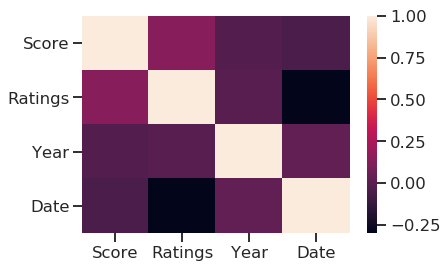

In [304]:
sns.heatmap(var_corr)

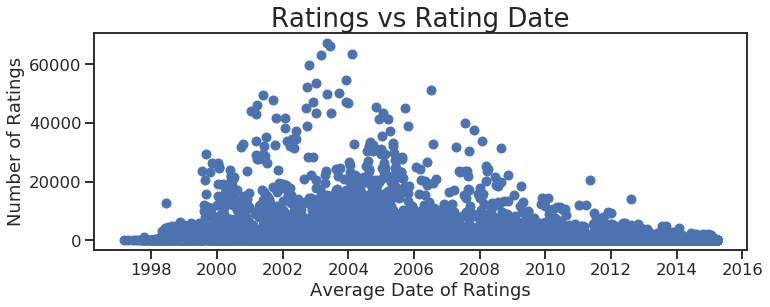

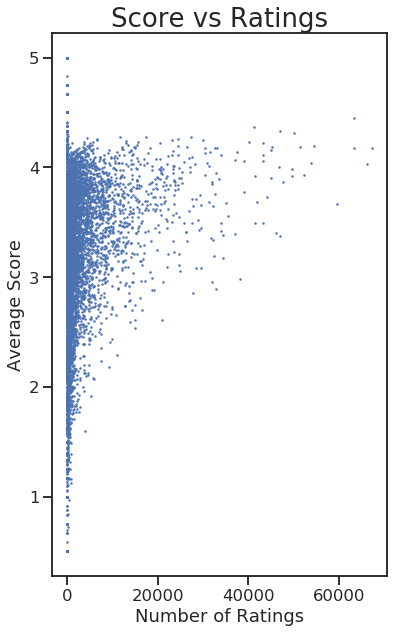

In [305]:
fig, axis = plt.subplots()
fig.set_size_inches(11.7, 4)
axis.set_title('Ratings vs Rating Date',fontsize=26)
axis.set_xlabel('Average Date of Ratings',fontsize=18)
axis.set_ylabel('Number of Ratings',fontsize=18)
plt.plot_date(x='Date', y = 'Ratings', data = merged_1)
plt.show();
fig, axis = plt.subplots()
fig.set_size_inches(6, 10)
axis.set_title('Score vs Ratings',fontsize=26)
axis.set_xlabel('Number of Ratings',fontsize=18)
axis.set_ylabel('Average Score',fontsize=18)
plt.scatter(x='Ratings', y = 'Score', marker = '.', s=4, data = merged_1)
plt.show();

## What's next?
* Bin 'Year' column into decades so I can color by the different buckets. Use this to compare to the clusters generated by kmeans clustering (color by either classification and compare side by side)
* Since I'm already familiar with ggplot, I would want to try to use [python ggplot](https://github.com/has2k1/plotnine) to color and facet by categorical variable and see if I can do something with it
Try using plotnine
`conda install -c conda-forge plotnine`

In [306]:
merged_1['Year'] = pd.to_numeric(merged_1['Year'])

/home/jcmint/anaconda3/envs/learningenv/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 3865'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/jcmint/anaconda3/envs/learningenv/lib/python3.7/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 19 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


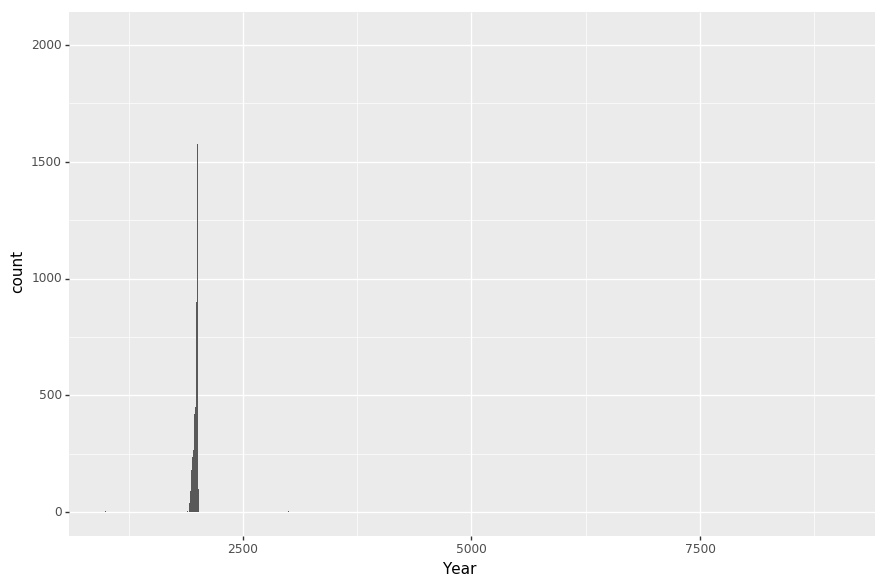

<ggplot: (8729985344730)>

In [307]:
from plotnine import ggplot, geom_point, aes, stat_smooth, geom_histogram
ggplot() + geom_histogram(aes('Year'), data = merged_1)

What is going on with the Year column of merged_1? Very odd, so I look at min and max.
# Further Data Cleaning

In [308]:
merged_1['Year'].min(), merged_1['Year'].max()
movies[movies['title'].str.contains('1000')]
movies[movies['title'].str.contains('9012')]
merged_1[merged_1['Year']==1000]
merged_1[merged_1['Year']==9012]

(1000.0, 9012.0)

,movieId,title,genres
6191,6290,House of 1000 Corpses (2003),Horror
7695,8198,"1000 Eyes of Dr. Mabuse, The (Die 1000 Augen d...",Crime|Horror|Mystery|Thriller
22287,107155,Captive Women (1000 Years from Now) (3000 A.D....,Sci-Fi
26429,126999,1000 Journals (2007),(no genres listed)


,movieId,title,genres
18578,92477,Yes: 9012 Live (1985),Documentary|Musical


,movieId,Score,Ratings,Date,Name,Year
6191,6290,2.855172,870,2007-08-23,House of 1000 Corpses,1000.0
7695,8198,3.398438,64,2008-06-21,"1000 Eyes of Dr. Mabuse, The",1000.0
22185,107155,0.500000,1,2014-04-13,Captive Women,1000.0
25962,126999,2.000000,1,2015-01-30,1000 Journals,1000.0


,movieId,Score,Ratings,Date,Name,Year
18533,92477,1.5,1,2012-01-22,Yes: 9012 Live,9012.0


I guess I could fiddle with the regex more but I'd rather just manually assign these and move on. I need to find the release years for the movie titles that were cut off first, and then find the correct index by the movieId in the merged dataframe. It seems like movie with Id 6290 wasn't actually misassigned since its year doesn't equal 1000 in the merged table.

In [309]:
print("Movie row number 7695, movieId 8198:", movies.iloc[7695, 1])
print("Movie row number 22287, movieId 107155:", movies.iloc[22287, 1])
# fixing the year = 1000 entry
merged_1[merged_1['movieId'] == 8198]
merged_1.iloc[7695, 5] = 1960
merged_1[merged_1['movieId'] == 107155]
merged_1.iloc[22185, 5] = 1960
merged_1[merged_1['movieId'] == 126999]
merged_1.iloc[25962, 5] = 2007
# Fixing the year = 9012 entry
merged_1[merged_1['movieId'] == 92477]
merged_1.iloc[18533, 5] = 1985

Movie row number 7695, movieId 8198: 1000 Eyes of Dr. Mabuse, The (Die 1000 Augen des Dr. Mabuse) (1960)
Movie row number 22287, movieId 107155: Captive Women (1000 Years from Now) (3000 A.D.) (1952)


,movieId,Score,Ratings,Date,Name,Year
7695,8198,3.398438,64,2008-06-21,"1000 Eyes of Dr. Mabuse, The",1000.0


,movieId,Score,Ratings,Date,Name,Year
22185,107155,0.5,1,2014-04-13,Captive Women,1000.0


,movieId,Score,Ratings,Date,Name,Year
25962,126999,2.0,1,2015-01-30,1000 Journals,1000.0


,movieId,Score,Ratings,Date,Name,Year
18533,92477,1.5,1,2012-01-22,Yes: 9012 Live,9012.0


In [310]:
merged_1['Year'].min(), merged_1['Year'].max()

(1000.0, 9000.0)

So at this point, I want to just find all the values from before 1900 and after 2018. Based on this the regex matching needs a bit of work to accurately grab values. Since I did want to focus more on machine learning rather than string manipulation for now I'll just drop these rows, since they only represent a tiny, tiny subset of data (I have 27 thousand rows)

In [311]:
cond_1 = merged_1['Year'] > 2016
cond_2 = merged_1['Year'] < 1900
merged_1[cond_1 | cond_2]
len(merged_1[cond_1 | cond_2])

,movieId,Score,Ratings,Date,Name,Year
662,671,3.676938,6361,2002-04-07,Mystery Science Theater 3000: The Movie,3000.0
1388,1422,3.058688,2820,2001-09-22,Murder at 1600,1600.0
2223,2308,2.800000,35,2004-01-05,Detroit 9000,9000.0
4065,4159,2.741048,1508,2005-07-06,3000 Miles to Graceland,3000.0
4216,4311,1.968750,16,2005-11-21,Bloody Angels,1732.0
5213,5310,2.311798,356,2004-05-23,Transylvania 6-5000,5000.0
5375,5472,3.452809,445,2006-01-24,1776,1776.0
6191,6290,2.855172,870,2007-08-23,House of 1000 Corpses,1000.0
6535,6645,3.454427,1152,2007-08-05,THX 1138,1138.0
8181,8864,2.640323,310,2007-03-22,Mr. 3000,3000.0


55

,movieId,Score,Ratings,Date,Name,Year


/home/jcmint/anaconda3/envs/learningenv/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 56'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/jcmint/anaconda3/envs/learningenv/lib/python3.7/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 19 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


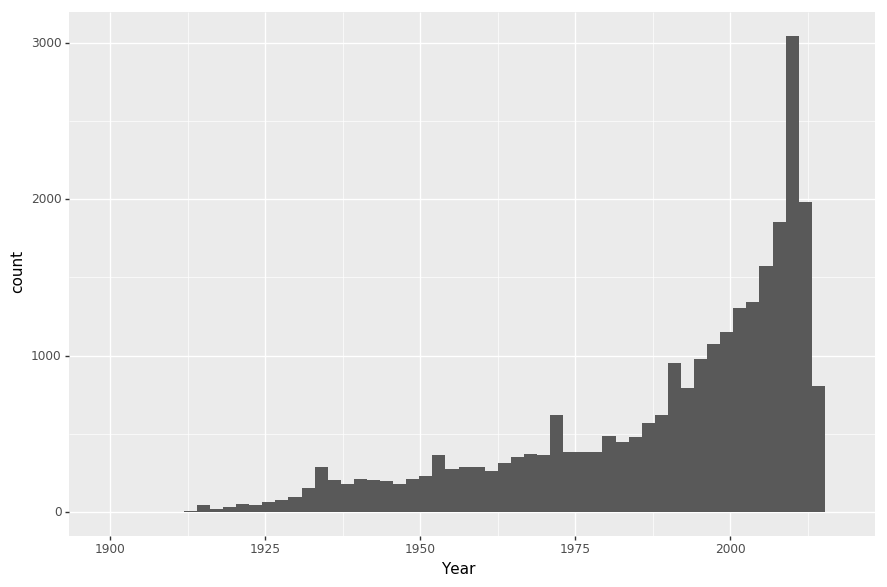

<ggplot: (-9223363306851432774)>

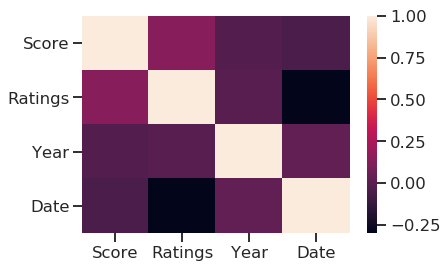

In [312]:
# drop buggy rows
merged_1 = merged_1[~(cond_1 | cond_2)]
cond_1 = merged_1['Year'] > 2016
cond_2 = merged_1['Year'] < 1900
merged_1[cond_1 | cond_2]
ggplot() + geom_histogram(aes('Year'), data = merged_1)
sns.heatmap(var_corr)

# Returning to visualization
Compare the heatmaps before and after removing the outlier years, and get a new scaled version

/home/jcmint/anaconda3/envs/learningenv/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jcmint/anaconda3/envs/learningenv/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


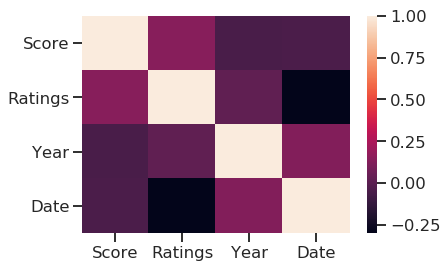

In [313]:
scaled_1 = merged_1.copy()
del scaled_1['Name']
del scaled_1['Date']
scaled_1 = scaled_1.merge(ratings[['movieId', 'timestamp']].groupby('movieId').mean().astype(int), on = 'movieId', how='inner')
del scaled_1['movieId']
scaled_1 = scaled_1.rename(columns={scaled_1.columns[3]: "Date"})
scaled_1['Year'] = pd.to_numeric(scaled_1['Year'])
var_corr = scaled_1.corr()
normalized = StandardScaler().fit_transform(scaled_1)
sns.heatmap(var_corr)

So it seems like the outliers and misidentified values had some influence on the Year correlation with other variables.
# Data Manipulations - Binning
Here, I want to bin the release year into decade buckets so that I can use that as a factor level to color the plots.

In [314]:
bins =  ["{0}s".format(decades) for decades in range(1900, 2020, 10)]
num_bins = len(bins)
scaled_1['decade'] = pd.cut(x=scaled_1['Year'], bins=num_bins, labels=bins)
scaled_1.head()
scaled_1.tail()

,Score,Ratings,Year,Date,decade
0,3.921240,49695,1995.0,1052654098,1990s
1,3.211977,22243,1995.0,1037616295,1990s
2,3.151040,12735,1995.0,959648019,1990s
3,2.861393,2756,1995.0,924214411,1990s
4,3.064592,12161,1995.0,962016085,1990s


,Score,Ratings,Year,Date,decade
26684,4.0,1,2007.0,1427743979,2010s
26685,4.0,1,2002.0,1427744888,2000s
26686,2.5,1,2014.0,1427745392,2010s
26687,3.0,1,2001.0,1427745466,2000s
26688,4.0,1,2014.0,1427747966,2010s


## Binning results
Plot all the data, divided by decade of release.

/home/jcmint/anaconda3/envs/learningenv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


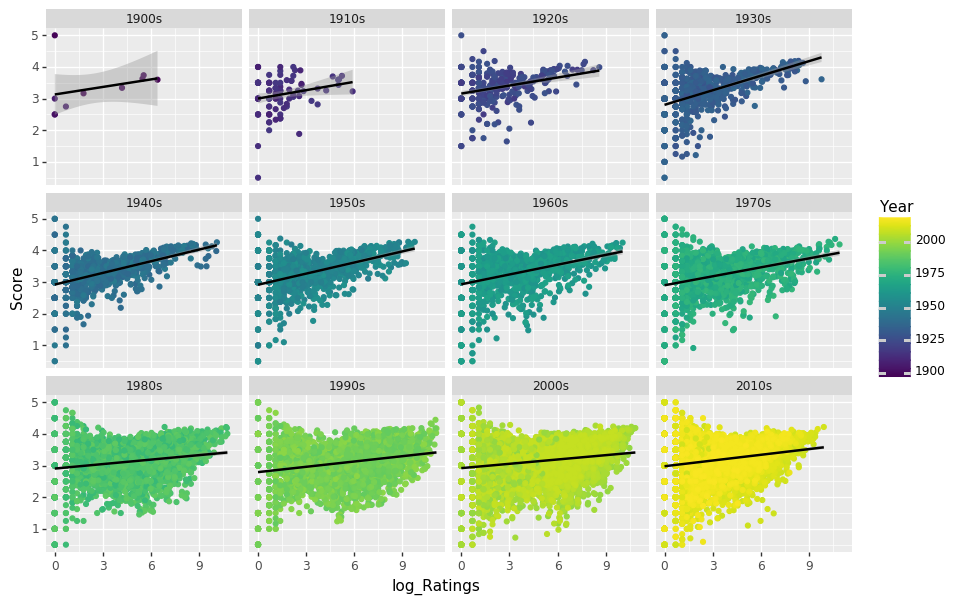

<ggplot: (8729992780783)>

In [315]:
# Drop na year values
scaled_1.dropna(inplace = True)
scaled_1['log_Ratings'] = np.log(scaled_1['Ratings'])
from plotnine import options as ops
from plotnine import facet_wrap
ops.figure_size = (10.4, 6.8)
ggplot(scaled_1, aes('log_Ratings', 'Score', color = 'Year')) + geom_point() + stat_smooth() + facet_wrap('~decade')

# Modeling
## Exploratory elbow plot
I generate an elbow plot to see how many clusters might be a good value.

In [316]:
%%capture
X = StandardScaler().fit_transform(scaled_1[['Score', 'Ratings', 'Date']])
error = []
for k in range(2, 20):
kmeans_model = KMeans(n_clusters = k);
kmeans_model.fit(X);
error.append(kmeans_model.inertia_);

,Clusters,Error
0,2,56811.269952
1,3,40924.920341
2,4,27773.559122
3,5,23374.464711
4,6,19266.801939
5,7,16360.115736
6,8,14559.723656
7,9,13013.149628
8,10,11561.152691
9,11,10591.417401


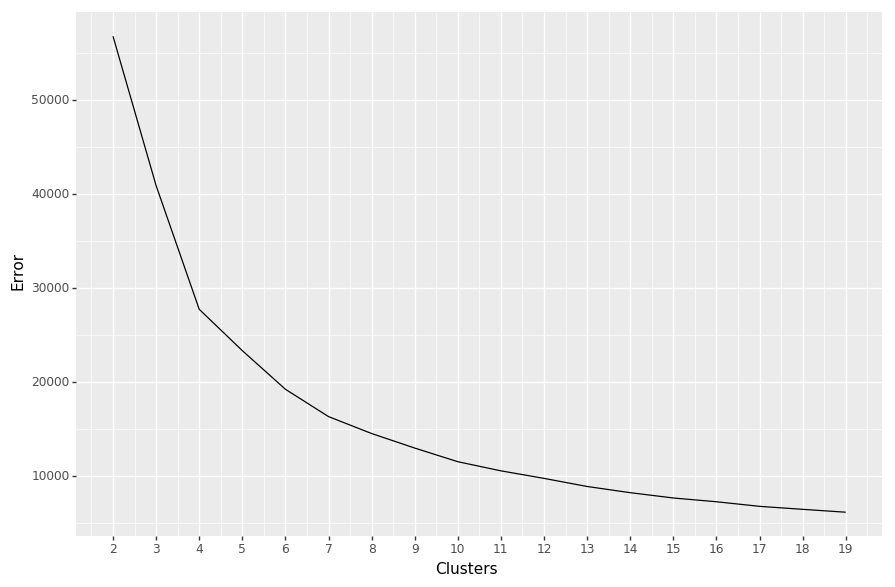

<ggplot: (-9223363306868393342)>

In [317]:
error = pd.Series(error)
elbow = pd.DataFrame({'Clusters': list(range(2,20)), 'Error' : error} )
elbow
from plotnine import geom_line
from plotnine import scale_x_continuous
ggplot(elbow, aes(x = 'Clusters', y = 'Error')) + geom_line() + scale_x_continuous(breaks = list(range(2,20)))

## Elbow plot - defining the bend mathematically
In most cases you would just eyeball the curve to see where the dropoff starts to plateau. But since we are using code and there are builtin functions we can easily grab the max of the second derivative as the point where the elbow plot is plateauing most quickly

In [318]:
np.diff(elbow['Error'])
np.diff(np.diff(elbow['Error']))
np.diff(np.diff(elbow['Error'])).max()

array([-15886.34961051, -13151.36121902,  -4399.09441152,  -4107.66277137,
        -2906.68620346,  -1800.3920797 ,  -1546.5740278 ,  -1451.99693761,
         -969.73528993,   -802.66399959,   -861.87052968,   -659.02715945,
         -564.39928912,   -400.28443027,   -487.72645071,   -318.78238598,
         -306.33237349])

array([2734.98839149, 8752.2668075 ,  291.43164015, 1200.97656791,
       1106.29412376,  253.8180519 ,   94.57709019,  482.26164768,
        167.07129033,  -59.20653009,  202.84337023,   94.62787033,
        164.11485886,  -87.44202044,  168.94406473,   12.45001249])

8752.266807496679

For added confirmation we can plot the first (blue line) and second (red line) derivatives. Indeed, the max of the 2nd derivative is at k = 5.

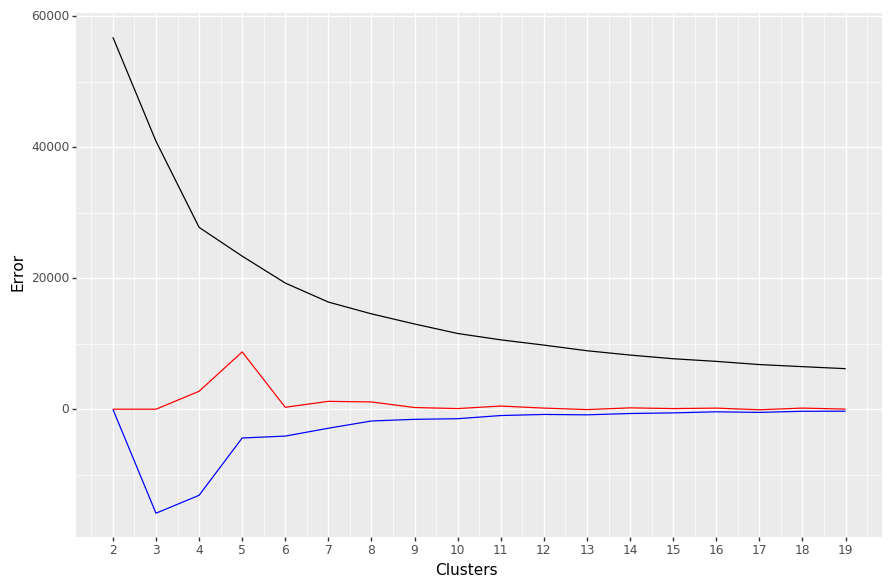

<ggplot: (8729990934669)>

In [319]:
diff_1 = [0]
elbow['First Derivative'] = np.append(np.array([0]), np.diff(elbow['Error']))
elbow['Second Derivative'] = np.append(np.array([0, 0]), np.diff(np.diff(elbow['Error'])))
elbow_d = ggplot(elbow, aes(x = 'Clusters', y = 'Error')) + geom_line() + scale_x_continuous(breaks = list(range(2,20)))
elbow_d + geom_line(aes(x = 'Clusters', y = 'First Derivative'), color = 'blue') + geom_line(aes(x = 'Clusters', y = 'Second Derivative'), color = 'red')

# Final cluster and visualization
From this plot we can see that the bend of the elbow plot is mathematically at k = 5 clusters. We can finally move on to the last part, return to using the KMeans model to generate label assignments, and color our data by the different clusters.

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

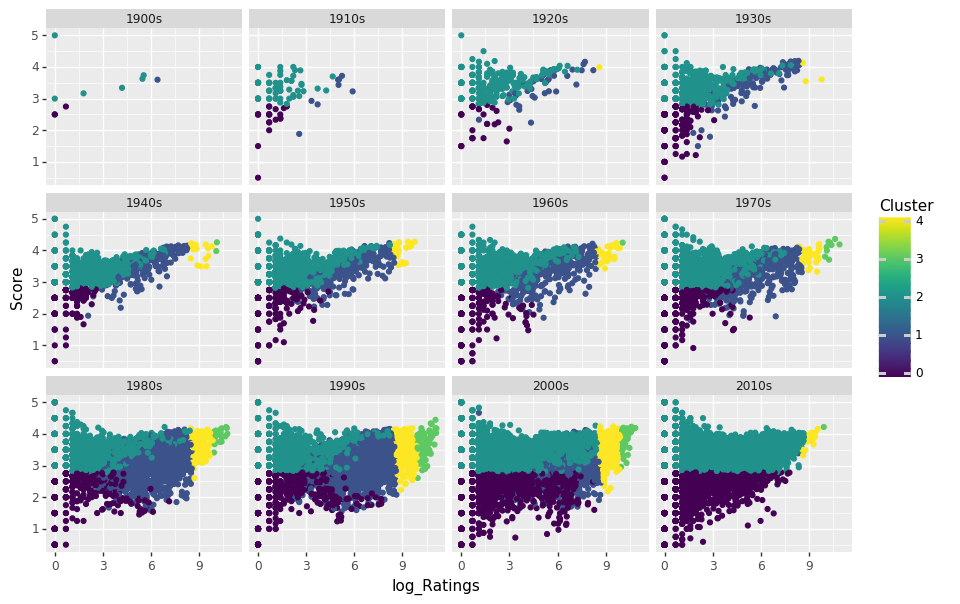

<ggplot: (-9223363306863402254)>

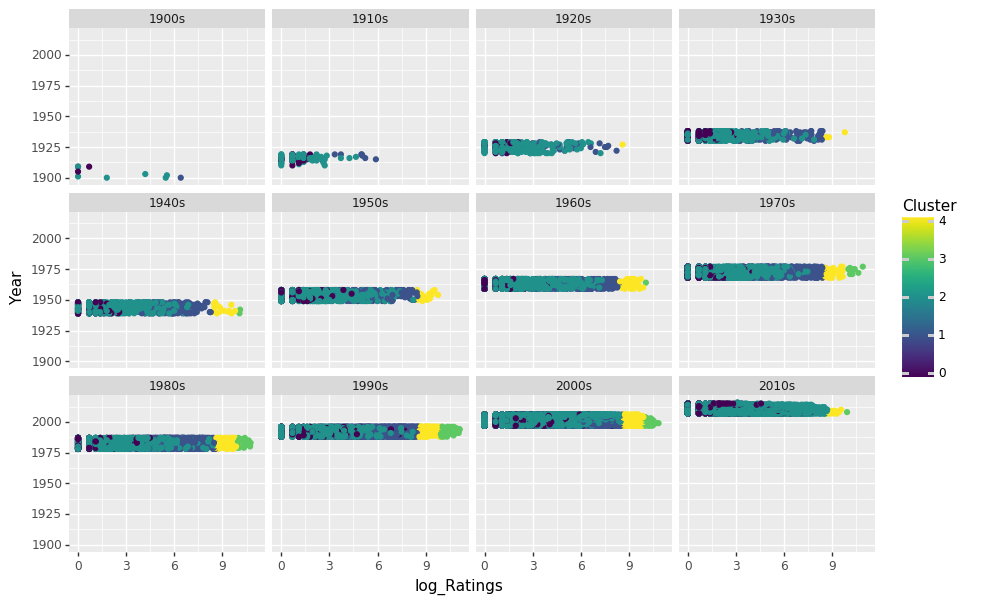

<ggplot: (8729991373488)>

In [320]:
kmeans_model = KMeans(n_clusters = 5);
kmeans_model.fit(X);
scaled_1['Cluster'] = kmeans_model.fit_predict(X)
ops.figure_size = (10.4, 6.8)
ggplot(scaled_1, aes('log_Ratings', 'Score', color = 'Cluster')) + geom_point() + facet_wrap('~decade')
ggplot(scaled_1, aes('log_Ratings', 'Year',  color = 'Cluster')) + geom_point() + facet_wrap('~decade')

Since I've faceted the graphs by decade of the movie release year, these plots are slices of a 3d plot. If we imagine that the Ratings and Score are the x and y dimensions when looking straight down, then the Year is the vertical dimensions. Here, I also I give a side view of the decade slices on the Ratings side. Finally, how long did this entire file take to run?

In [321]:
time_stop = datetime.datetime.now()
time_stop - time_start

datetime.timedelta(seconds=46, microseconds=211675)